In [2]:
import time
import os, copy, random, sys
import itertools
import io


import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler, ConcatDataset

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


sys.path.insert(0,'/Users/admin/Documents/GitHub/SkinCancer/src')
# from config import args_parser 
from models import *
from dataset import SkinCancer
from dataset import CIFAR100Dataset

# from sklearn.utils import class_weight
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

/Users/admin/Documents/Github/SkinCancer/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [12]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45,fontsize=8,horizontalalignment='right')
    plt.yticks(tick_marks, class_names,fontsize=8)
    
    # Normalize the confusion matrix.
    # cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color,fontsize=7)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure


In [25]:


def train_epoch(model, device, dataloader, loss_fn, optimizer, classes_to_augment=None):
    train_loss, train_correct = 0.0, 0
    model.train()
    
    # Define data augmentation transformations
    augmentation_transform = transforms.Compose([
        # Add your desired data augmentation techniques here
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])
    
    for images, labels in dataloader:
        labels_list = labels.cpu().numpy()
        images_list = images.cpu().numpy()
        
        # print(labels.items())
        # Apply data augmentation if the class is in classes_to_augment
        if labels.item() in classes_to_augment:
            
            images = augmentation_transform(images)
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
        # print(f'train_epoch(): Batch => {Counter(labels.cpu().numpy().tolist())}')
                    
    return train_loss, train_correct

  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    y_true,y_pred = [], []
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        
        val_correct+=(predictions == labels).sum().item()
        

        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        
        
    # y_true = np.array(y_true)
    # y_pred = np.array(y_pred)
    # cf_matrix = confusion_matrix(y_true, y_pred)
    
    

    return valid_loss,val_correct

In [14]:
def test_inference(model,device,dataloader,loss_fn,class_names):
                                                           
    test_loss, test_correct = 0.0, 0
    model.eval()
    y_true,y_pred = [], [] # Use for Confusion Matrix
    y_t,y_p = [], [] # Use for Metrics (f1, precision, recall)
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        output = model(images)
        loss=loss_fn(output,labels)
        test_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        
        test_correct+=(predictions == labels).sum().item()
        

        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        
        y_t.append(labels.cpu().numpy())
        y_p.append(predictions.cpu().numpy())
        
        

    cf_matrix = confusion_matrix(y_true, y_pred)
    
    cf_figure = plot_confusion_matrix(cf_matrix, class_names)
    
#     f_l = [f1_score(p, t, average='macro') for t,p in zip(y_t, y_p)]
#     p_l = [precision_score(p, t, average='macro') for t,p in zip(y_t, y_p)]
#     r_l = [recall_score(p, t, average='macro') for t,p in zip(y_t, y_p)]
#     # auc_l = [roc_auc_score(p.cpu().numpy(), t.cpu().numpy(), multi_class='ovr') for t,p in zip(y_true,y_pred)]
    
#     f1_s = sum(f_l)/len(f_l)
#     # print('f1:', f1_s)
#     p_s = sum(p_l)/len(p_l)
#     r_s = sum(r_l)/len(r_l)
    
    
    
    # m_dict = pd.DataFrame({'F1_Score' : f1_s,
    #       'Precision' : p_s, 
    #       'Recall' : r_s})
    
    
    # metrics_table.add_data(f1_s,p_s,r_s)
    
    
#     wandb.log({"Testing-Confusion-Matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds = y_pred, class_names = class_names)})
    
#     wandb.log({"Metrics-Table": wandb.Table(columns=['F1_Score','Precision','Recall'], data=[[f1_s, p_s, r_s]])})
    

    return test_loss,test_correct, cf_figure, cf_matrix

In [15]:
# k=5
# splits=KFold(n_splits=k,shuffle=True,random_state=42)


# ======================= DATA ======================= #

data_dir = '../data/HAM10k/HAM10000_images'




dataset = SkinCancer(data_dir, '../csv/train.csv', transform=None)
dataset_size = len(dataset)

test_dataset = SkinCancer(data_dir, '../csv/test.csv', transform=None)



# ======================= Model | Loss Function | Optimizer ======================= # 





AttributeError: 'SkinCancer' object has no attribute '__Len__'

In [17]:
model = resnet()

In [7]:
model.load_state_dict(torch.load('../models/EfficientNet_original_10Epochs.pth'))

<All keys matched successfully>

In [67]:
img, label = dataset.__getitem__(0)
type(label.tolist())

int

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self,x):
        return x

In [8]:
# Second Test
# model.avgpool = Identity()
model.classifier = nn.Sequential(
    nn.BatchNorm1d(num_features=1280),    
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(0.4),
    nn.Linear(512, 7),
    )
# print(model)

In [9]:
# tune_layers = ['fc', 'classifier']

# This function finetunes only fc layers 
# Another test would be to add new classifier and tune that
def fine_tunemodel(model):
    for name, param in model.named_parameters():
        if not 'classifier' in name:
            # if not 'classifier' in name:
            param.requires_grad = False
        # print(name, param.requires_grad)
    return model

In [ ]:
model = fine_tunemodel(model)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

In [19]:
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
batch_size = 16
class_names = dataset.classes
epochs=5

logger = SummaryWriter(log_dir = f'../tb_logs/{model._get_name()}/original_finetuning_classifier_R3_{epochs}Epochs')


In [26]:


# ======================= Start ======================= #
start_t = time.time() 

best_acc = 0.0

step = 0
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)



# args.finetune = 'finetune' if args.finetune else 'transfer'

fine_tune = True

if os.name == 'posix' and torch.backends.mps.is_available(): # device is mac m1 chip
    print(f"<----------Using MPS--------->")
    device = 'mps'
elif os.name == 'nt' and torch.cuda.is_available(): # device is windows with cuda
    print(f'"<----------Using CUDA--------->')
    device = args.device
else:
    print(f'"<----------Using CPU--------->')
    device = 'cpu'


# class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(dataset.classes),y=np.array(dataset.classes_all))
# class_weights=torch.FloatTensor(class_weights).to(device)
#             # class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(dataset.classes),y=self.df['dx'].to_numpy()),device='cuda')
# criterion = nn.CrossEntropyLoss(weight = class_weights,reduction='mean') 

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold))
    print('Model {}'.format(model._get_name()))
    # print('Wandb Run Name: {}'.format(wandb.run.name))


    # model.load_state_dict(MODEL_WEIGHTS) # uncomment to start fresh for each fold


    model.to(device)

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler) # train, will change for each fold
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler) # validation 
    test_loader = DataLoader(test_dataset, batch_size=batch_size) # hold out set, test once at the end of each fold


    classes_to_augment = ['akiec', 'df']
# ======================= Train per fold ======================= #
    for epoch in range(epochs):
        step+=1
        train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer, classes_to_augment)
        val_loss, val_correct = valid_epoch(model,device,val_loader,criterion)
        test_loss_epoch, test_acc_epoch, cf_figure, _ = test_inference(model,device,test_loader,criterion,class_names)
        logger.add_figure("Confusion Matrix Epoch", cf_figure, step)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print(f"Epoch: {epoch}/{epochs},\n AVG Training Loss:{train_loss} \t Testing Loss{val_loss}\nAVG Training Acc: {train_acc} % \t Testing Acc {val_acc}")


        test_loss_epoch = test_loss_epoch / len(test_loader.sampler)
        test_acc_epoch = test_acc_epoch / len(test_loader.sampler) * 100


        # print("Epoch:{}/{}\nAVG Training Loss:{:.3f} \t Testing Loss:{:.3f}\nAVG Training Acc: {:.2f} % \t Testing Acc {:.2f} % ".format(epoch, args.epochs, train_loss,  val_loss, train_acc,  val_acc))
        
        


# ======================= Save per Epoch ======================= #

        logger.add_scalars('Loss', {'train':train_loss,
                                'val':val_loss,
                                'test':test_loss_epoch}, step)

        logger.add_scalars('Acc', {'train':train_acc,
                                'val':val_acc,
                                'test':test_acc_epoch}, step)



        # ======================= Save model if new high accuracy ======================= #
        if test_acc_epoch > best_acc:
            print('#'*25)
            print('New High Acc: ', test_acc_epoch)
            print('#'*25)
            best_acc = test_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'../models/{model._get_name()}_original_finetuning_{epochs}Epochs.pth')
            

            # Save Scripted Model 
            scripted_model = torch.jit.script(model)
            torch.jit.save(scripted_model, f'../models/scripted_{model._get_name()}_original_finetuning_{epochs}Epochs.pt')

        
        if step == 10:
            model =fine_tunemodel(model)
            # lambda p: p.requires_grad, model.parameters()
            optimizer = torch.optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
            
            print('FineTuning Stage')



# ======================= Test Model on HOS ======================= #

    test_loss, test_correct, cf_figure_fold, cf_matrix = test_inference(model,device,test_loader,criterion,class_names)

    logger.add_figure("Confusion Matrix Fold", cf_figure_fold, fold)

    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_correct / len(test_loader.sampler) * 100

    np.save(f'../output_files/cf_matrix/{model._get_name()}_original_finetuning_classifier_Fold{fold}.npy', cf_matrix)




    # print("Fold:{}/{}\nTesting Loss:{:.3f} \t Testing Acc:{:.3f}% ".format(fold,test_loss, test_acc))
    # print(f"Fold:{fold}\nTesting Loss:{test_loss} \t Testing Acc:{test_acc}%")
    # wandb.log({"Fold Test": {"test_loss" : test_loss,
    #                          "test_acc" : test_acc}})

    logger.add_scalar('Fold/Acc', test_acc, fold)
    logger.add_scalar('Fold/Loss', test_loss, fold)


# 


# ======================= Save model if new high accuracy ======================= #
#     if test_acc > best_acc:
#         print('#'*25)
#         print('New High Acc: ', test_acc)
#         print('#'*25)
#         best_acc = test_acc
#         best_model_wts = copy.deepcopy(model.state_dict())
#         torch.save(model.state_dict(), f'../models/{model._get_name()}_{args.modality}_{args.finetune}_{args.epochs}Epochs.pth')

#         # Save Scripted Model 
#         scripted_model = torch.jit.script(model)
#         torch.jit.save(scripted_model, f'../models/scripted_{model._get_name()}_{args.modality}_{args.finetune}_{args.epochs}Epochs.pt')

end_train = time.time()
time_elapsed = start_t - end_train

print(f'{model._get_name()} Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')


<----------Using MPS--------->
Fold 0
Model ResNet


RuntimeError: a Tensor with 16 elements cannot be converted to Scalar

In [ ]:
ipykernel
ipython
jupyter_client
jupyter_core
traitlets
ipython_genutils

In [28]:
from imports import *

In [44]:
cf_v2 = np.load('../output_files/cf_matrix/ResNet_augmented_transfer_Fold4.npy')
cf_org = np.load('../output_files/cf_matrix/ResNet_original_Fold4.npy')
cf_aug = np.load('../output_files/cf_matrix/ResNet_augmented_finetune_Fold3.npy')
cf_noAug = np.load('../output_files/cf_matrix/ResNet_Notaugmented_transfer_Fold4.npy')

In [40]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
path = '../output_files/cf_matrix/ResNet_augmented_transfer_Fold4.npy'
cm = np.load(path)

import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt), horizontalalignment="center", color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Replace 'confusion_matrix' with your actual NumPy array and 'class_names' with your class labels
confusion_matrix = np.array([[34, 3, 12, 1, 7, 8, 0],
                             [11, 69, 9, 0, 2, 12, 0],
                             [8, 2, 180, 0, 7, 23, 0],
                             [2, 1, 4, 8, 2, 6, 0],
                             [4, 2, 41, 3, 97, 75, 1],
                             [0, 2, 35, 3, 18, 1282, 1],
                             [0, 0, 0, 0, 0, 2, 26]])





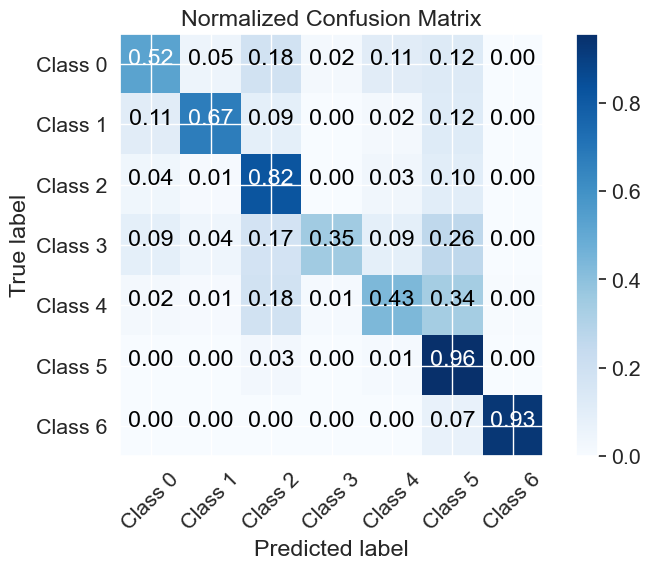

In [41]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]

plot_confusion_matrix(cf_v2, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

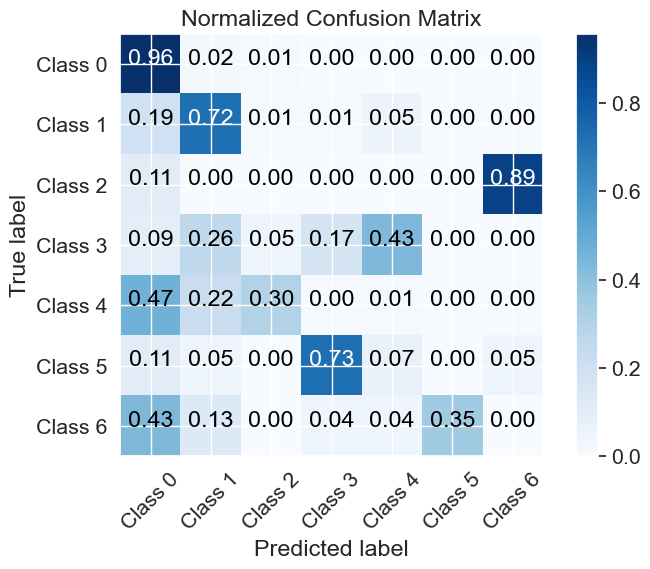

In [42]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]

plot_confusion_matrix(cf_org, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

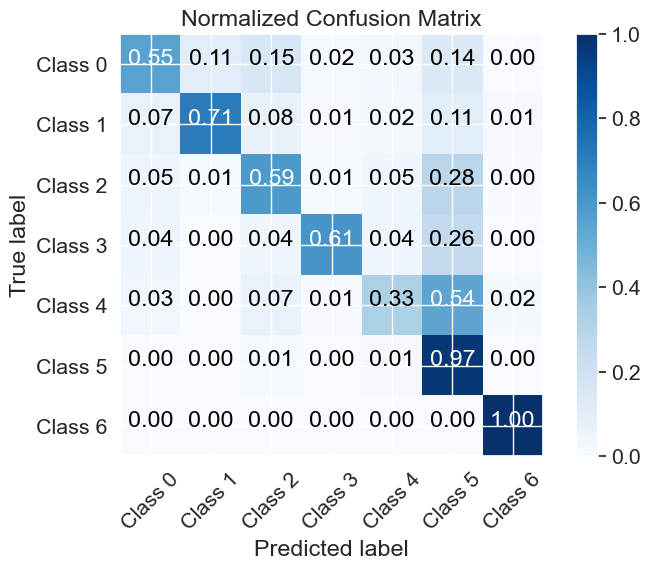

In [43]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]

plot_confusion_matrix(cf_aug, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

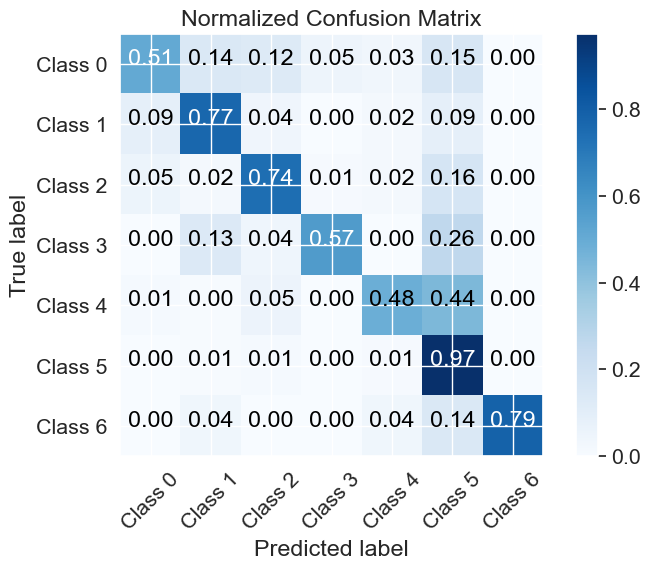

In [45]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]

plot_confusion_matrix(cf_noAug, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

In [50]:
import numpy as np
import cv2
from imports import *

image_path = '../data/HAM10k/HAM10000_images/ISIC_0024306.jpg'
image = cv2.imread(image_path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.2),  # Randomly convert to grayscale
    transforms.ToPILImage(),
    ])
img = transform(image)
type(img)

PIL.Image.Image

In [5]:
import pycm
import numpy
cf_aug = numpy.load('../output_files/cf_matrix/ResNet_augmented_all_Test.npy')
cf= numpy.load('../output_files/cf_matrix/ResNet_original_Fold4.npy')
cm_aug = pycm.ConfusionMatrix(matrix=cf_aug)
cm = pycm.ConfusionMatrix(matrix=cf)

print(f'\t Original \t Augmented')
for key in cm.class_stat['F1'].keys():
    print(f"{key}: {cm.class_stat['F1'][key]}, {cm_aug.class_stat['F1'][key]}")

	 Original 	 Augmented
0: 0.6260869565217392, 0.5048543689320388
1: 0.8252427184466019, 0.7547169811320755
2: 0.7894736842105263, 0.7223476297968398
3: 0.6976744186046512, 0.5833333333333334
4: 0.636604774535809, 0.6525821596244131
5: 0.935148692225009, 0.9359351988217968
6: 0.8928571428571429, 0.896551724137931


In [4]:
cm.overall_stat

{'Overall ACC': 0.8741887169246131,
 'Overall RACCU': 0.508920842400902,
 'Overall RACC': 0.507839090091772,
 'Kappa': 0.7443696146066403,
 'Gwet AC1': 0.8629735804801772,
 'Bennett S': 0.8532201697453818,
 'Kappa Standard Error': 0.015056180158763635,
 'Kappa Unbiased': 0.7438065103587732,
 'Scott PI': 0.7438065103587732,
 'Kappa No Prevalence': 0.7483774338492262,
 'Kappa 95% CI': (0.7148595014954636, 0.773879727717817),
 'Standard Error': 0.00741006332667932,
 '95% CI': (0.8596649928043216, 0.8887124410449045),
 'Chi-Squared': 6701.282628575252,
 'Phi-Squared': 3.3456228799676744,
 'Cramer V': 0.7467287414636896,
 'Response Entropy': 1.4575580290003882,
 'Reference Entropy': 1.6309094854007267,
 'Cross Entropy': 1.6461863410689692,
 'Joint Entropy': 2.2163497661778315,
 'Conditional Entropy': 0.5854402807771051,
 'Mutual Information': 0.8721177482232831,
 'KL Divergence': 0.015276855668242412,
 'Lambda B': 0.5443037974683544,
 'Lambda A': 0.6193353474320241,
 'Chi-Squared DF': 36,
 

### CIFAR100


In [1]:
import sys
sys.path.insert(0,'/Users/admin/Documents/GitHub/SkinCancer/src')
# from config import args_parser 
from models import *
from dataset import SkinCancer
from dataset import CIFAR100
import pickle

/Users/admin/Documents/Github/SkinCancer/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
with open('../data/CIFAR100/meta', 'rb') as f:
    meta = pickle.load(f, encoding='bytes')
    print(f"Meta keys: {meta.keys()}")

with open('../data/CIFAR100/train', 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    print(f"train keys: {train.keys()}")
    

Meta keys: dict_keys([b'fine_label_names', b'coarse_label_names'])
train keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [3]:
train = CIFAR100('../data/CIFAR100/train', '../data/CIFAR100/meta', transform=None)
train.__getitem__(0)[0].size()

torch.Size([3, 224, 224])